In [19]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [20]:
df = pd.read_csv('E:\Projects\Automated_Hyperparameter_Tuning-Time-Series-LSTM\seattle-weather.csv')
df_tempmax1 = df["temp_max"]
df_tempmin = df["temp_min"]
df_wind = df["wind"]
df_weather = df["weather"]
print(df.head())

         date  precipitation  temp_max  temp_min  wind  weather
0  2012-01-01            0.0      12.8       5.0   4.7  drizzle
1  2012-01-02           10.9      10.6       2.8   4.5     rain
2  2012-01-03            0.8      11.7       7.2   2.3     rain
3  2012-01-04           20.3      12.2       5.6   4.7     rain
4  2012-01-05            1.3       8.9       2.8   6.1     rain


<Axes: ylabel='temp_max'>

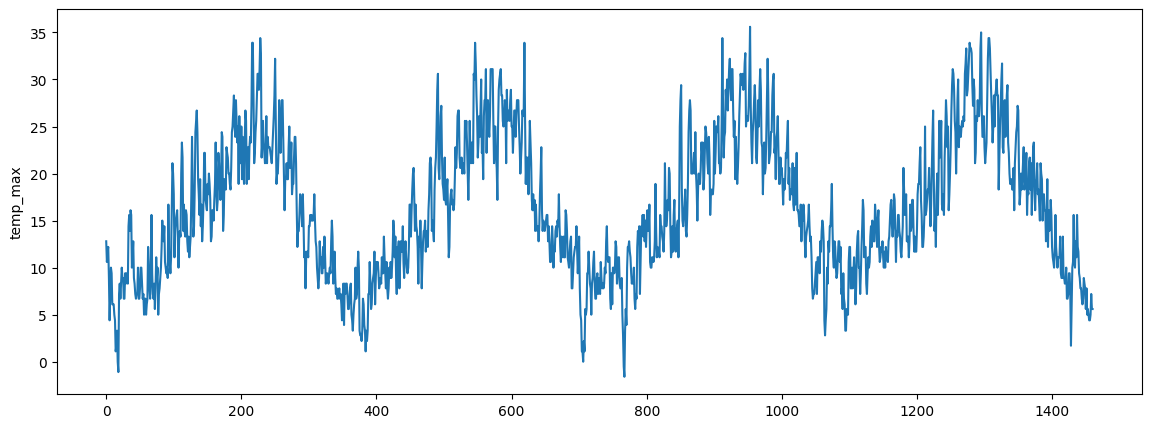

In [7]:
plt.figure(figsize=(14,5))
sns.lineplot(df_tempmax1)

In [21]:
def df_to_XY(df,window_size=10):
    df_np = df_tempmax1.to_numpy()
    X = []
    y = []
    for i in range(len(df_np)-window_size):
        row = [[a] for a in df_np[i:i+window_size]]
        X.append(row)
        target = df_np[i+window_size]
        y.append(target)
    return np.array(X),np.array(y)

In [22]:
WINDOW = 10
X,y = df_to_XY(df,WINDOW)
print(len(X),len(y))
X_train = X[:800]
y_train = y[:800]
X_val = X[800:1000]
y_val = y[800:1000]
X_test = X[1000:]
y_test = y[1000:]

1451 1451


In [23]:
X.shape

(1451, 10, 1)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score

In [25]:
model = Sequential()
model.add(LSTM(64,input_shape=(WINDOW,1),activation = "relu"))
model.add(Dense(32,activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(16,activation = "relu"))
model.add(Dense(1,activation = "linear"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 19521 (76.25 KB)
Trainable params: 19521 (76.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
callback1 = ModelCheckpoint('model/',save_best_only=True)
earlyStopping = EarlyStopping(monitor="val_root_mean_squared_error",patience=3,start_from_epoch=5,restore_best_weights=True,)
model.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.0001),metrics=RootMeanSquaredError())

In [27]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[earlyStopping])

Epoch 1/100
25/25 [==============================] - 2s 23ms/step - loss: 187.4010 - root_mean_squared_error: 13.6894 - val_loss: 256.4628 - val_root_mean_squared_error: 16.0145
Epoch 2/100
25/25 [==============================] - 0s 10ms/step - loss: 133.0500 - root_mean_squared_error: 11.5347 - val_loss: 147.7479 - val_root_mean_squared_error: 12.1552
Epoch 3/100
25/25 [==============================] - 0s 10ms/step - loss: 69.4907 - root_mean_squared_error: 8.3361 - val_loss: 48.2584 - val_root_mean_squared_error: 6.9468
Epoch 4/100
25/25 [==============================] - 0s 10ms/step - loss: 33.0577 - root_mean_squared_error: 5.7496 - val_loss: 24.0939 - val_root_mean_squared_error: 4.9086
Epoch 5/100
25/25 [==============================] - 0s 10ms/step - loss: 31.2078 - root_mean_squared_error: 5.5864 - val_loss: 20.9279 - val_root_mean_squared_error: 4.5747
Epoch 6/100
25/25 [==============================] - 0s 10ms/step - loss: 27.0304 - root_mean_squared_error: 5.1991 - val_

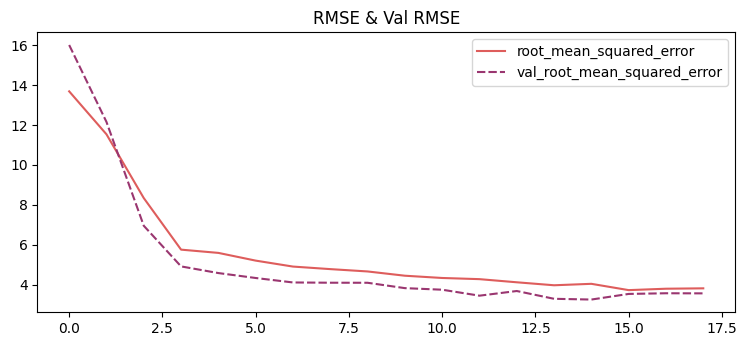

In [28]:
his = pd.DataFrame(history.history)
his.columns
history_rmse =  his[['root_mean_squared_error', 'val_root_mean_squared_error']]

plt.figure(figsize=(9,8))
plt.subplot(2,1,2)
plt.title("RMSE & Val RMSE")
sns.lineplot(history_rmse,palette="flare");

In [29]:
train_pred = model.predict(X_train).flatten()
val_pred = model.predict(X_val).flatten()
test_pred = model.predict(X_test).flatten()

15/15 [==============================] - 0s 5ms/step


<Axes: title={'center': 'Test Results'}>

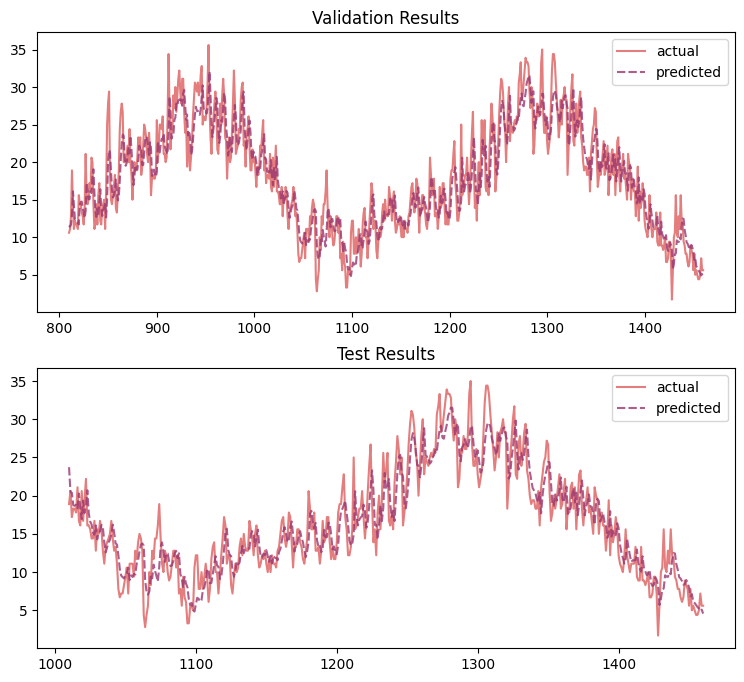

In [30]:
pred = np.concatenate([train_pred, val_pred, test_pred])
df_pred = pd.DataFrame(df["temp_max"].copy())
df_pred.columns = ["actual"]
df_pred = df_pred[WINDOW:]
df_pred["predicted"] = pred

fig, axes = plt.subplots(2, 1, figsize=(9, 8))
plt.subplot(2, 1, 1)
plt.title("Validation Results")
sns.lineplot(df_pred[800:], alpha=0.8, palette="flare", linestyle=None)

plt.subplot(2, 1, 2)
plt.title("Test Results")
sns.lineplot(df_pred[1000:], alpha=0.8, palette="flare", linestyle=None)

In [32]:
r2_test = r2_score(y_test, test_pred)
print(f"R2 Score on Test Data: {r2_test:.4f}")

R2 Score on Test Data: 0.8390


In [33]:
num_future_days = 20
initial_sequence = test_pred[-WINDOW:]

predicted_temperatures = []

for day in range(num_future_days):
    input_sequence = initial_sequence[-WINDOW:].reshape(1, WINDOW, 1)
    next_day_prediction = model.predict(input_sequence)[0, 0]
    predicted_temperatures.append(next_day_prediction)

    initial_sequence = np.append(initial_sequence, next_day_prediction)
    initial_sequence = initial_sequence[1:]

1/1 [==============================] - 0s 28ms/step


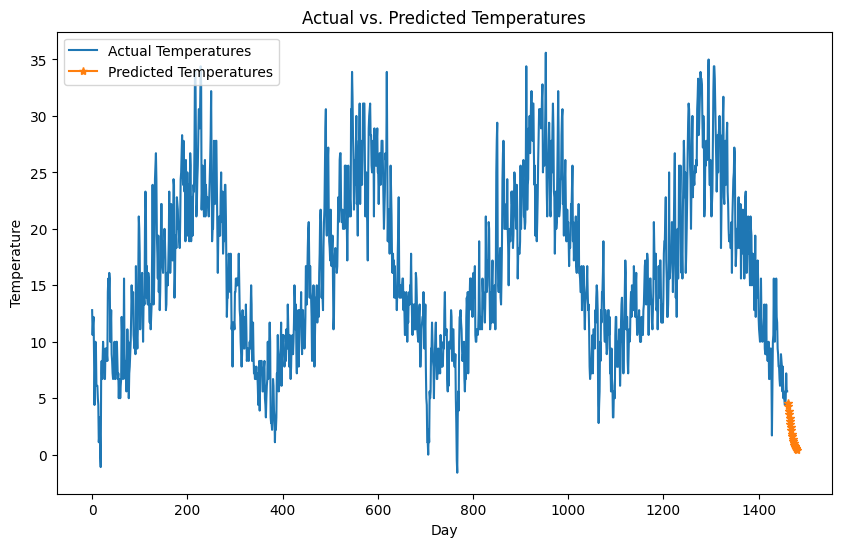

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(df_tempmax1, label='Actual Temperatures')
plt.plot(np.arange(len(df_tempmax1), len(df_tempmax1) + num_future_days),
         predicted_temperatures, label='Predicted Temperatures', marker='*')
plt.xlabel('Day')
plt.ylabel('Temperature')
plt.title('Actual vs. Predicted Temperatures')
plt.legend()
plt.show()

Automated hyperparameter tuning using KERAS TUNER

In [18]:
pip install keras_tuner

Note: you may need to restart the kernel to use updated packages.


In [45]:
from tensorflow.keras.models import Sequential
from kerastuner.tuners import RandomSearch
from kerastuner import Objective
from kerastuner.engine.hyperparameters import HyperParameters

In [46]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), input_shape=(WINDOW, 1)))
    model.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=64, step=16), activation=hp.Choice('dense_activation', values=['relu', 'sigmoid', 'tanh', 'linear'])))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation=hp.Choice('output_activation', values=['relu', 'sigmoid', 'tanh', 'linear'])))
    
    model.compile(loss=MeanSquaredError(), 
                  optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  metrics=[RootMeanSquaredError()])
    return model

In [48]:
tuner = RandomSearch(
    build_model,
    objective=Objective('val_root_mean_squared_error', direction='min'),
    max_trials=5,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='weather_forecast1'
)

In [49]:
tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=10,
             callbacks=[EarlyStopping(patience=3)])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[EarlyStopping(patience=3)])


Trial 5 Complete [00h 00m 08s]
val_root_mean_squared_error: 3.111281633377075

Best val_root_mean_squared_error So Far: 3.111281633377075
Total elapsed time: 00h 00m 40s
Epoch 1/100
25/25 [==============================] - 3s 30ms/step - loss: 160.2233 - root_mean_squared_error: 12.6579 - val_loss: 114.2809 - val_root_mean_squared_error: 10.6902
Epoch 2/100
25/25 [==============================] - 0s 10ms/step - loss: 43.4425 - root_mean_squared_error: 6.5911 - val_loss: 40.6157 - val_root_mean_squared_error: 6.3730
Epoch 3/100
25/25 [==============================] - 0s 11ms/step - loss: 15.4773 - root_mean_squared_error: 3.9341 - val_loss: 15.9861 - val_root_mean_squared_error: 3.9983
Epoch 4/100
25/25 [==============================] - 0s 10ms/step - loss: 13.7089 - root_mean_squared_error: 3.7025 - val_loss: 13.0276 - val_root_mean_squared_error: 3.6094
Epoch 5/100
25/25 [==============================] - 0s 10ms/step - loss: 13.6813 - root_mean_squared_error: 3.6988 - val_loss: 13

In [50]:
train_pred = model.predict(X_train).flatten()
val_pred = model.predict(X_val).flatten()
test_pred = model.predict(X_test).flatten()

15/15 [==============================] - 0s 4ms/step


<Axes: title={'center': 'Test Results'}>

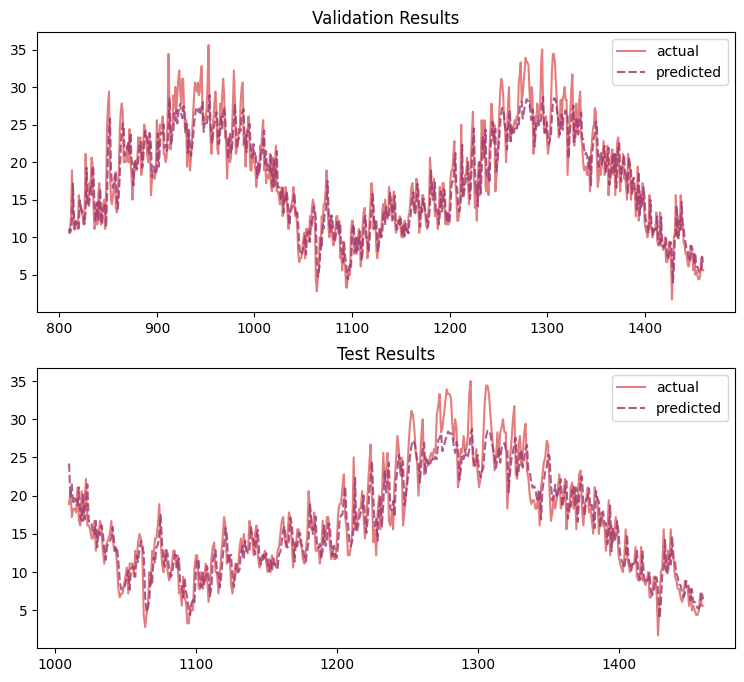

In [51]:
pred = np.concatenate([train_pred, val_pred, test_pred])
df_pred = pd.DataFrame(df["temp_max"].copy())
df_pred.columns = ["actual"]
df_pred = df_pred[WINDOW:]
df_pred["predicted"] = pred

fig, axes = plt.subplots(2, 1, figsize=(9, 8))
plt.subplot(2, 1, 1)
plt.title("Validation Results")
sns.lineplot(df_pred[800:], alpha=0.8, palette="flare", linestyle=None)

plt.subplot(2, 1, 2)
plt.title("Test Results")
sns.lineplot(df_pred[1000:], alpha=0.8, palette="flare", linestyle=None)

In [52]:
r2_test = r2_score(y_test, test_pred)
print(f"R2 Score on Test Data: {r2_test:.4f}")

R2 Score on Test Data: 0.8485
